In [1]:
import argparse
import logging
import os
import time

import numpy as np
import rembg
import torch
from PIL import Image

from tsr.system import TSR
from tsr.utils import remove_background, resize_foreground, save_video
no_remove_bg = False
image = ['examples/unicorn.png']
images = []
foreground_ratio = 0.85
if no_remove_bg:
    rembg_session = None
else:
    rembg_session = rembg.new_session()
for i, image_path in enumerate(image):
    if no_remove_bg:
        image = np.array(Image.open(image_path).convert("RGB"))
    else:
        image = remove_background(Image.open(image_path), rembg_session)
        image = resize_foreground(image, foreground_ratio)
        image = np.array(image).astype(np.float32) / 255.0
        image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
        image = Image.fromarray((image * 255.0).astype(np.uint8))
        # if not os.path.exists(os.path.join(output_dir, str(i))):
        #     os.makedirs(os.path.join(output_dir, str(i)))
        # image.save(os.path.join(output_dir, str(i), f"input.png"))
    images.append(image)

/root/data/anaconda3/envs/pixellm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from triplane_clip import TriPlaneCLIPConfig, TriPlaneCLIPModel, TriPlaneCLIPVisionModelWithProjection, TriPlaneCLIPVisionConfig
from transformers import CLIPModel, CLIPVisionModelWithProjection, CLIPTextModelWithProjection, CLIPProcessor
config = TriPlaneCLIPConfig()
config.vision_config.image2triplane_model = "ckpts/TripoSR"
# vision_config.image2triplane_mode
vision = TriPlaneCLIPVisionModelWithProjection.from_pretrained('work_dir/ckpts/iter_10000').cuda()
triplane_clip = TriPlaneCLIPModel(config).cuda()
# triplane_clip = TriPlaneCLIPModel.from_pretrained('work_dir/ckpts/iter_10000').cuda()
clip = CLIPModel.from_pretrained("ckpts/clip-vit-large-patch14").cuda()
# vision = TriPlaneCLIPVisionModelWithProjection.from_pretrained('work_dir/ckpts/iter_10000').cuda()
# clip_vision = CLIPVisionModelWithProjection.from_pretrained("ckpts/clip-vit-large-patch14").cuda()

processor = CLIPProcessor.from_pretrained("ckpts/clip-vit-large-patch14")

Some weights of TriPlaneCLIPVisionModelWithProjection were not initialized from the model checkpoint at work_dir/ckpts/iter_10000 and are newly initialized: ['visual_projection.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [5]:
triplane_clip.cuda()

TriPlaneCLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

In [3]:
triplane_clip.vision_model = vision.vision_model
triplane_clip.text_model = clip.text_model
triplane_clip.visual_projection = clip.visual_projection
triplane_clip.text_projection = clip.text_projection

In [6]:
inputs = processor(text=['a cat', 'a dog', 'a unicorn'], return_tensors="pt")
for key, value in inputs.items():
    inputs[key] = value.cuda()
inputs['images'] = images
out = triplane_clip(**inputs)

In [ ]:
triplane_clip.save_pretrained('ckpts/triplaneclip-vit-large-patch14')
processor.save_pretrained('ckpts/triplaneclip-vit-large-patch14')

In [8]:
out.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

In [10]:
(out.logits_per_image*10).softmax(-1)

tensor([[0.0821, 0.1429, 0.7750]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [3]:
vision.visual_projection = clip_vision.visual_projection

In [4]:
clip_text = CLIPTextModelWithProjection.from_pretrained("ckpts/clip-vit-large-patch14").cuda()

In [5]:
import torch
out = vision(images = images)
# out = vision(pixel_values = scene_tokens)

In [6]:
out.image_embeds.shape

torch.Size([1, 768])

In [7]:
inputs = processor(images=image, return_tensors="pt")
for key, value in inputs.items():
    inputs[key] = value.cuda()
clip_out = clip_vision(**inputs)
clip_out.image_embeds.shape

torch.Size([1, 768])

In [8]:
inputs = processor(text=['a cat', 'a dog', 'a unicorn'], return_tensors="pt")
for key, value in inputs.items():
    inputs[key] = value.cuda()
clip_text_out = clip_text(**inputs)
clip_text_out.text_embeds.shape

torch.Size([3, 768])

In [9]:
# image_embeds = clip_out.image_embeds / clip_out.image_embeds.norm(p=2, dim=-1, keepdim=True)
image_embeds = out.image_embeds / out.image_embeds.norm(p=2, dim=-1, keepdim=True)
text_embeds = clip_text_out.text_embeds / clip_text_out.text_embeds.norm(p=2, dim=-1, keepdim=True)
logit_scale = 100
logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
logits_per_image = logits_per_text.t()
logits_per_image.softmax(-1)

tensor([[0.1372, 0.2023, 0.6605]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [19]:
len(img_names)

661577

In [20]:
ids, captions3d = caption_3d['id'].to_list(), caption_3d['caption3d'].to_list()

In [23]:
import random
caption3d_template = [
    "Describe the 3D model concisely.",
    "Provide a brief description of the given 3D model.",
    "Offer a succinct explanation of the 3D model presented.",
    "Summarize the visual content of the 3D model.",
    "Give a short and clear explanation of the subsequent 3D model.",
    "Share a concise interpretation of the 3D model provided.",
    "Present a compact description of the 3D model key features.",
    "Relay a brief, clear account of the 3D model shown.",
    "Render a clear and concise summary of the 3D model.",
    "Write a terse but informative summary of the 3D model.",
    "Create a compact narrative representing the 3D model presented.",
]

In [25]:
random.choice(caption3d_template)

'Relay a brief, clear account of the 3D model shown.'

In [26]:
target_json = []
for i in tqdm(range(len(ids))):
    tmp_dict = {}
    id = ids[i]
    caption3d = captions3d[i]
    image = f'data/objaverse/Cap3D_imgs_view0/{id}'
    tmp_dict['id'] = id
    tmp_dict['image'] = image
    conversations = []
    conversation = {}
    conversation['from'] = 'human'
    question = random.choice(caption3d_template)
    conversation['value'] = f'<triplane>\n{question}'
    conversations.append(conversation)
    conversation = {}
    conversation['from'] = 'gpt'
    conversation['value'] = f'{caption3d}'
    conversations.append(conversation)
    tmp_dict['conversations'] = conversations
    target_json.append(tmp_dict)

100%|██████████| 549921/549921 [00:02<00:00, 194740.55it/s]


In [27]:
target_json[0]

{'id': '53d0b31aa7f84bc4b1733224963d0114',
 'image': 'data/objaverse/Cap3D_imgs_view0/53d0b31aa7f84bc4b1733224963d0114',
 'conversations': [{'from': 'human',
   'value': '<triplane>\nPresent a compact description of the 3D model key features.'},
  {'from': 'gpt',
   'value': '3D rendering of a white sofa with wooden legs and frame.'}]}

In [28]:
import json
with open('data/objaverse/cap3d_automated_objaverse_highquality_550k.json', 'w') as f:
    json.dump(target_json, f)

In [29]:
json.load(open('data/objaverse/cap3d_automated_objaverse_highquality_550k.json'))[0]

{'id': '53d0b31aa7f84bc4b1733224963d0114',
 'image': 'data/objaverse/Cap3D_imgs_view0/53d0b31aa7f84bc4b1733224963d0114',
 'conversations': [{'from': 'human',
   'value': '<triplane>\nPresent a compact description of the 3D model key features.'},
  {'from': 'gpt',
   'value': '3D rendering of a white sofa with wooden legs and frame.'}]}

In [21]:
# new_ids, new_captions3d = [], []
# for i in tqdm(range(len(ids))):
#     id = ids[i]
#     caption3d = captions3d[i]
#     if id in img_names:
#         new_ids.append(id)
#         new_captions3d.append(caption3d)

  0%|          | 1901/549921 [00:10<50:37, 180.39it/s]  


KeyboardInterrupt: 

In [22]:
len(new_ids)

1901

In [ ]:

image2caption = {}
for data in tqdm(caption_3d):
    image2caption[data[0]] = data[1]

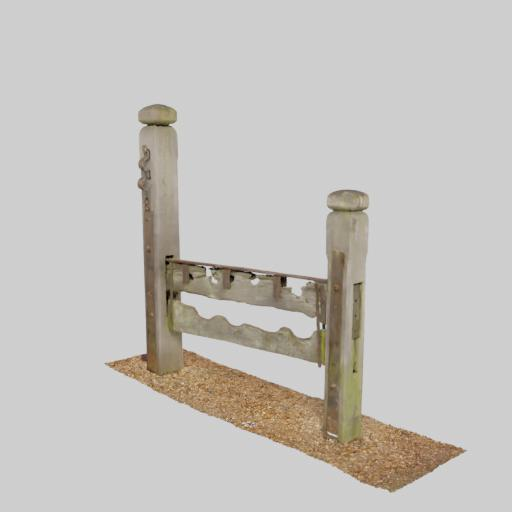

In [15]:
image = Image.open('data/objaverse/Cap3D_imgs_view0/25f25e35aada40e49194657fd51c1199')
image